# KLD CUSIP Correction

<div class="alert alert-block alert-warning">
<b>Warning:</b> KLD does not provide CUSIP before 1994. Also, some CUSIP digits are wrongly shifted by omitting one or two zeros in front. When backfill please also set '0', 'NA' and '#N/A' as missing value first.
</div>

## Obtain Data

In [1]:
import wrds
import matplotlib.pyplot as plt

In [2]:
db = wrds.Connection()

Loading library list...
Done


In [3]:
kld = db.get_table(library='kld', table='history', columns=['companyname', 'cusip', 'ticker', 'companyid', 'year', 'domicile'])
kld.shape

(53168, 6)

In [4]:
kld.sort_values(['year', 'ticker'], inplace=True);

For example, look at the CUSIP of Apple. CUSIP before 1995 is missing and some CUSIP-8-digit wrongly recorded as "37833100" instead of "03783310"!

In [5]:
kld[kld['ticker']=='AAPL']

,companyname,cusip,ticker,companyid,year,domicile
1632,"Apple Computer, Inc.",None,AAPL,None,1991.0,None
1633,"Apple Computer, Inc.",None,AAPL,None,1992.0,None
1634,"Apple Computer, Inc.",None,AAPL,None,1993.0,None
1635,"Apple Computer, Inc.",None,AAPL,None,1994.0,None
1636,"Apple Computer, Inc.",03783310,AAPL,None,1995.0,None
1637,"Apple Computer, Inc.",03783310,AAPL,None,1996.0,None
1638,"Apple Computer, Inc.",03783310,AAPL,None,1997.0,None
1640,"Apple Computer, Inc.",03783310,AAPL,None,1998.0,None
1641,"Apple Computer, Inc.",03783310,AAPL,None,1999.0,None
1642,"Apple Computer, Inc.",37833100,AAPL,None,2000.0,None


To correct the wrongly shifted CUSIPs, I first shift the CUSIP digits to the right and add "0"'s in front. Then take the first 8 digits and compare them to the original 8-digit-CUSIP. If there're sets of intersection, this means there are wrongly shifted CUSIPs. I collect this set of wrongly shifted CUSIPs and create a dictionary to map them back to the correct CUSIPs correspondingly.

In [6]:
kld['0cusip7']='0' + kld['cusip'].str[0:7]
kld['00cusip6']= '00' + kld['cusip'].str[0:6]
kld['000cusip5']= '000' + kld['cusip'].str[0:5]

The list of CUSIPs that requires adding '0' in front:

In [7]:
lst111=kld['cusip'].unique()
lst222=kld['0cusip7'].unique()
lst8 = sorted(list(set(lst111) & set(lst222)))
len(lst8)

274

The list of CUSIPs that requires adding '00' in front:

In [8]:
lst1111=kld['cusip'].unique()
lst2222=kld['00cusip6'].unique()
lst88 = sorted(list(set(lst1111) & set(lst2222)))
len(lst88)

59

The list of CUSIPs that requires adding '000' in front:

In [9]:
lst11111=kld['cusip'].unique()
lst22222=kld['000cusip5'].unique()
lst888 = sorted(list(set(lst11111) & set(lst22222)))
len(lst888)

5

Create dictionary mapping wrong CUSIPs to their corresponding correct CUSIPs: 

In [10]:
# one zero added in front
rcdict0 = {}
for c in lst8:
    if len(set(kld[kld['0cusip7']==c]['cusip']))==1:
        #print(len(set(kld[kld['0cusip7']==c]['cusip']))==1) # check if wrongly shifted cusip-8-digit is unique
        _c = list(kld[kld['0cusip7']==c]['cusip'])[0]
    rcdict0[_c] = c

In [11]:
# two zero added in front
lst88.remove('00030710')
rcdict00 = {}
for c in lst88:
    if len(set(kld[kld['00cusip6']==c]['cusip']))==1:
        #print(len(set(kld[kld['00cusip6']==c]['cusip']))==1) # check if wrongly shifted cusip-8-digit is unique
        _c = list(kld[kld['00cusip6']==c]['cusip'])[0]
    rcdict00[_c] = c

In [12]:
# three zero added in front
lst888.remove('00030710')
rcdict000 = {}
for c in lst888:
    if len(set(kld[kld['000cusip5']==c]['cusip']))==1:
        #print(len(set(kld[kld['00cusip6']==c]['cusip']))==1) # check if wrongly shifted cusip-8-digit is unique
        _c = list(kld[kld['000cusip5']==c]['cusip'])[0]
    rcdict000[_c] = c

In [13]:
# Some hand maps
cusip6Dict = {"18772103":"01877210",
              "01877230":"01877210",
              "886309":"00088630"}

Merging all dictionaries above:

In [14]:
cusipDict = {**rcdict0, **rcdict00, **rcdict000, **cusip6Dict}

Check the total length of key-value pairs:

In [15]:
len(cusipDict) == len(rcdict0) + len(rcdict00) + len(rcdict000) + len(cusip6Dict)

True

Uncommment the rows in next cell will print all wrong CUSIP observations.

In [16]:
counter = 0
for d in cusipDict.keys():
    #print('Wrong CUSIP: ' + str(d) + ' | Corresponding correct CUSIP: ' + str(cusipDict[d]) + '\n')
    #print(kld[kld.cusip==d][['companyname', 'cusip', 'ticker', 'companyid', 'year']])
    count = len(kld[kld.cusip==d])
    counter += count
    #print('\nNumber of wrong CUSIP observations: ' + str(count))
    #print('\nCumulated wrong CUSIP observations: ' + str(counter)
    #      + '\n============================================================================\n\n')
print('\nTotal number of distinct wrong CUSIP: ' + str(len(cusipDict)))
print('\nToral wrong CUSIP observations: ' + str(counter))


Total number of distinct wrong CUSIP: 339

Toral wrong CUSIP observations: 1968


Wrong CUSIP distribution by year:

In [17]:
wrongCusipObs = kld[kld.cusip.isin(cusipDict.keys())]

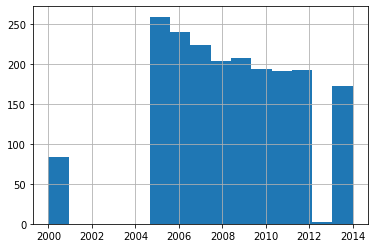

In [18]:
wrongCusipObs['year'].astype(int).hist(bins=15)

## Correction by assigning according to the dictionary constructed above

Create a column to store original CUSIP column:

In [19]:
kld['cusip_orig'] = kld['cusip']

In [20]:
for d in cusipDict.keys():
    kld.loc[kld.cusip==d, 'cusip'] = cusipDict[d]

In [21]:
kld.drop(columns=['0cusip7', '00cusip6', '000cusip5'], inplace=True)

Check any wrong Cusip observation left again:

In [22]:
len(kld[kld.cusip.isin(cusipDict.keys())])

0

Check again for example, the CUSIP of Apple. Before correction, CUSIP before 1995 is missing and some CUSIP-8-digit wrongly recorded as "37833100" instead of "03783310"!

In [23]:
kld[kld['ticker']=='AAPL']

,companyname,cusip,ticker,companyid,year,domicile,cusip_orig
1632,"Apple Computer, Inc.",None,AAPL,None,1991.0,None,None
1633,"Apple Computer, Inc.",None,AAPL,None,1992.0,None,None
1634,"Apple Computer, Inc.",None,AAPL,None,1993.0,None,None
1635,"Apple Computer, Inc.",None,AAPL,None,1994.0,None,None
1636,"Apple Computer, Inc.",03783310,AAPL,None,1995.0,None,03783310
1637,"Apple Computer, Inc.",03783310,AAPL,None,1996.0,None,03783310
1638,"Apple Computer, Inc.",03783310,AAPL,None,1997.0,None,03783310
1640,"Apple Computer, Inc.",03783310,AAPL,None,1998.0,None,03783310
1641,"Apple Computer, Inc.",03783310,AAPL,None,1999.0,None,03783310
1642,"Apple Computer, Inc.",03783310,AAPL,None,2000.0,None,37833100
